In [1]:
import jwst
import os,re,sys,copy
from jwst.datamodels import ImageModel
from jwst import datamodels
import astropy.units as u
import pysiaf
from pdastro import makepath,rmfile,pdastroclass,pdastrostatsclass,AnotB,unique
from astropy.io import fits
import numpy as np
from astropy.modeling.models import Polynomial2D, Mapping, Shift
from scipy import linalg
import pandas as pd
import glob
from astropy.coordinates import SkyCoord

# define colnames of input tables
colnames={}
colnames['x']='x'
colnames['y']='y'
colnames['mag']='mag'
colnames['dmag']='dmag'
colnames['ra']='gaia_ra'
colnames['dec']='gaia_dec'

def v2v3_idl_model(from_sys, to_sys, par, angle):
    """
    Creates an astropy.modeling.Model object
    for the undistorted ("ideal") to V2V3 coordinate translation
    """
    if from_sys != 'v2v3' and to_sys != 'v2v3':
        raise ValueError("This function is designed to generate the transformation either to or from V2V3.")

    # Cast the transform functions as 1st order polynomials
    xc = {}
    yc = {}
    if to_sys == 'v2v3':
        xc['c1_0'] = par * np.cos(angle)
        xc['c0_1'] = np.sin(angle)
        yc['c1_0'] = (0.-par) * np.sin(angle)
        yc['c0_1'] = np.cos(angle)

    if from_sys == 'v2v3':
        xc['c1_0'] = par * np.cos(angle)
        xc['c0_1'] = par * (0. - np.sin(angle))
        yc['c1_0'] = np.sin(angle)
        yc['c0_1'] = np.cos(angle)

    #0,0 coeff should never be used.
    xc['c0_0'] = 0
    yc['c0_0'] = 0

    xmodel = Polynomial2D(1, **xc)
    ymodel = Polynomial2D(1, **yc)

    return xmodel, ymodel

def polyfit0(u, x, y, order):
    """Fit polynomial to a set of u values on an x,y grid.
    u is a function u(x,y) being a polynomial of the form
    u = a[i, j] x**(i-j) y**j. x and y can be on a grid or be arbitrary values
    This version uses scipy.linalg.solve instead of matrix inversion.
    u, x and y must have the same shape and may be 2D grids of values.
    
    **** NOTE: in this routine coeffs[0] is kept at 0! ****
    
    Parameters
    ----------
    u : array
        an array of values to be the results of applying the sought after
        polynomial to the values (x,y)
    x : array
        an array of x values
    y : array
        an array of y values
    order : int
        the polynomial order
    Returns
    -------
    coeffs: array
        polynomial coefficients being the solution to the fit.
    """
    # First set up x and y powers for each coefficient
    px = []
    py = []
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Important: start the power at 1, not 0!
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    for i in range(1,order + 1):
        for j in range(i + 1):
            px.append(i - j)
            py.append(j)
    terms = len(px)

    # Make up matrix and vector
    vector = np.zeros((terms))
    mat = np.zeros((terms, terms))
    for i in range(terms):
        vector[i] = (u * x ** px[i] * y ** py[i]).sum()  # Summing over all x,y
        for j in range(terms):
            mat[i, j] = (x ** px[i] * y ** py[i] * x ** px[j] * y ** py[j]).sum()

    coeffs = linalg.solve(mat, vector)
    coeffs0 = [0]
    coeffs0.extend(coeffs)
    return coeffs0




**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [8]:
filtername = 'F335M'
pupilname = 'MASKRND'
verbose=1
# correct v2/v3 
correctV2V3Flag=True

# this can be 'header', 'siafaperture', or 'center'. defines from where the target V2/V3ref 
# and V3idlYAng values are taken from
V2V3ref_method = 'center' 

In [9]:
inputrootdir = '/Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd'
fullimagenames = glob.glob(f'{inputrootdir}/jw01481*_nrcalong_jhat.fits')
print(f'{len(fullimagenames)} images found')

6 images found


In [10]:
# this is preparing the images and getting the information like siaf aperture

# only keep images with correct filter and puppil
fullimagenames_filter=[]
apernamelist = []
instrumentlist =[]
v2refs_hdr=[]
v3refs_hdr=[]
v3yangs_hdr=[]
for fullimagename in fullimagenames:
    hdr0 = fits.getheader(fullimagename)
    hdr1 = fits.getheader(fullimagename,ext=1)
    print(f'{hdr0["FILTER"].upper()} {hdr0["PUPIL"].upper()}')
    #image_model = ImageModel(fullimagename)
    #if image_model.meta.instrument.filter.upper()!=filtername:
    if hdr0["FILTER"].upper()!=filtername:
        if verbose>1: print (f'filter={hdr0["FILTER"].upper()}!={filtername}: Skipping {fullimagename} ')
        continue
    if hdr0["PUPIL"].upper()!=pupilname:
        if verbose>1: print (f'filter={hdr0["PUPIL"].upper()}!={pupilname}: Skipping {fullimagename} ')
        continue
    print (f'Keeping {fullimagename} {hdr0["FILTER"]} {hdr0["PUPIL"]}')
    fullimagenames_filter.append(fullimagename)
    apernamelist.append(hdr0['APERNAME'])
    instrumentlist.append(hdr0['INSTRUME'])
    v2refs_hdr.append(hdr1["V2_REF"])
    v3refs_hdr.append(hdr1["V3_REF"])
    v3yangs_hdr.append(hdr1["V3I_YANG"])

# just use 2 images for debugging
# fullimagenames_filter=fullimagenames_filter[:1]

print(f'{len(fullimagenames_filter)} images found with correct filter={filtername} and pupil={pupilname}')
if len(fullimagenames_filter)<1:
    raise RuntimeError('No images!!')

apernamelist = unique(apernamelist)
instrumentlist = unique(instrumentlist)
if len(apernamelist)!=1: raise RuntimeError(f'more than 1 apertures!! {apernamelist}')
if len(instrumentlist)!=1: raise RuntimeError(f'more than 1 apertures!! {instrumentlist}')

if verbose: print(f'initializing siaf aperture for {instrumentlist[0]} {apernamelist[0]}')
siaf_instrument = pysiaf.Siaf(instrumentlist[0]) 
siaf_aperture = siaf_instrument.apertures[apernamelist[0]]

if V2V3ref_method.lower() == 'header':
    if len(v2refs_hdr)!=1: raise RuntimeError(f'V2_REF list from header does not exactly have one entry: {v2refs_hdr}')
    if len(v3refs_hdr)!=1: raise RuntimeError(f'V3_REF list from header does not exactly have one entry: {v3refs_hdr}')
    if len(v3yangs_hdr)!=1: raise RuntimeError(f'V3I_YANG list from header does not exactly have one entry: {v3yangs_hdr}')
    target_v2ref = float(v2refs_hdr[0])
    target_v3ref = float(v3refs_hdr[0])
    target_V3IdlYAngle = float(v3yangs_hdr[0])
elif V2V3ref_method.lower() == 'siafaperture':
    target_v2ref = siaf_aperture.V2Ref
    target_v3ref = siaf_aperture.V3Ref
    target_V3IdlYAngle = siaf_aperture.V3IdlYAngle
elif V2V3ref_method.lower() == 'center':
    # nothing to do yet!
    target_v2ref = None
    target_v3ref = None
    target_V3IdlYAngle = None
else:
    raise RuntimeError(f'{V2V3ref_method} not allowed for V2V3ref_method, only header, siafaperture, center allowed')

print(f'V2V3ref_method={V2V3ref_method}: target (V2ref,V3ref,V3IdlYAngle)=({target_v2ref},{target_v3ref},{target_V3IdlYAngle})')


F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002001_04101_00001_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002001_04101_00002_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481001002_04101_00002_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481001002_04101_00001_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002002_04101_00001_nrcalong_jhat.fits F335M MASKRND
F335M MASKRND
Keeping /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002002_04101_00002_nrcalong_jhat.fits F335M MASKRND
6 images found with correct filter=F335M and pupil=MASKRND
initializing siaf aperture for NIRCAM NRCA5_FULL
V2V3ref_method=c

In [11]:
debug=True

# Load the tables, calculate refcat v2/v3 from refcat ra,dec, and populate detector info columns
frames = {}
imtable=pdastroclass()
for counter,fullimagename in enumerate(fullimagenames_filter):
    imagename = os.path.basename(fullimagename)
    goodtablefilename = re.sub('\.fits$','.good.phot.txt',fullimagename)
    # Load the table into hash
    frames[counter] = pd.read_csv(goodtablefilename,sep='\s+')
    if len(frames[counter])<1:
        raise RuntimeError(f'file {goodtablefilename} has no data!')

    # only keep relevant columns
    frames[counter] = frames[counter][list(colnames.values())].copy()
    
    # save the filename and assign ID
    frames[counter]['imagename']=imagename
    frames[counter]['imID']=counter
    
    # Get detector info and save in table
    image_model = ImageModel(fullimagename)
    #print(image_model.meta.instance) 
    #print(image_model.meta.instrument.filter)
    #print(image_model.meta.instrument.instance)

    frames[counter]['instrument']=image_model.meta.instrument.name
    frames[counter]['detector']=image_model.meta.instrument.detector
    frames[counter]['aperture']=image_model.meta.aperture.name
    frames[counter]['filter']=image_model.meta.instrument.filter
    frames[counter]['pupil']=image_model.meta.instrument.pupil
    
    ix_im = imtable.newrow({
        'imID':counter,
        'image':imagename,
        'fullimage':fullimagename,
        'aperture':image_model.meta.aperture.name,
        'filter':image_model.meta.instrument.filter,
        'pupil':image_model.meta.instrument.pupil
    })
    
    # Calculate v2/v3 from refcat ra/dec
    # This should be independent of the distortions, it just depends if the WCS alignment is good
    # enough with default distortions
    world_to_v2v3 = image_model.meta.wcs.get_transform('world', 'v2v3')
    (frames[counter]['refcat_v2'], frames[counter]['refcat_v3']) = world_to_v2v3(frames[counter][colnames['ra']],frames[counter][colnames['dec']])

    # original xy to radec, including default distortions
    detector_to_world = image_model.meta.wcs.get_transform('detector', 'world')
    (frames[counter]['ra_old'], frames[counter]['dec_old']) = detector_to_world(frames[counter][colnames['x']],frames[counter][colnames['y']])

    # original radec to xy, including default distortions
    world_to_detector = image_model.meta.wcs.get_transform('world', 'detector')
    (frames[counter]['refcat_x'], frames[counter]['refcat_y']) = world_to_detector(frames[counter][colnames['ra']],frames[counter][colnames['dec']])

    #siaf_instrument = pysiaf.Siaf(image_model.meta.instrument.name) 
    #siaf_aperture = siaf_instrument.apertures[image_model.meta.aperture.name]

    # just a check
    scihdr = fits.getheader(fullimagename,extname='SCI')
    print(f'V2V3 header: ({scihdr["V2_REF"]:.6f},{scihdr["V3_REF"]:.6f})')

    detector_to_v2v3 = image_model.meta.wcs.get_transform('detector', 'v2v3')
    v2center,v3center = detector_to_v2v3(siaf_aperture.XSciRef-1.0,siaf_aperture.YSciRef-1.0)
    
    v2_1,v3_1 = detector_to_v2v3(siaf_aperture.XSciRef-1.0,siaf_aperture.YSciRef-1.0+0.5)
    v2_2,v3_2 = detector_to_v2v3(siaf_aperture.XSciRef-1.0,siaf_aperture.YSciRef-1.0-0.5)
    pos1 = SkyCoord(ra=v2_1, dec=v3_1, unit=(u.arcsec,u.arcsec), frame='icrs')
    pos2 = SkyCoord(ra=v2_2, dec=v3_2, unit=(u.arcsec,u.arcsec), frame='icrs')
    V3IdlYAngle_center = pos1.position_angle(pos2).to(u.deg)
    if V3IdlYAngle_center.degree>90: 
        V3IdlYAngle_center-=180.0*u.deg
    if V3IdlYAngle_center.degree<-90:
        V3IdlYAngle_center+=180.0*u.deg

    if V2V3ref_method.lower() == 'center':
        target_v2ref = float(v2center)
        target_v3ref = float(v3center)
        target_V3IdlYAngle = float(V3IdlYAngle_center.degree)
    
    dv2 = target_v2ref - v2center
    dv3 = target_v3ref - v3center
    print(f'V2V3 comparison: ({target_v2ref:.6f},{target_v3ref:.6f}) ({v2center},{v3center})')
    print(f'Difference dV2={dv2:.6f} dV3={dv3:.6f}')

    frames[counter]['v2ref'] = target_v2ref
    frames[counter]['v3ref'] = target_v3ref

    imtable.t.loc[ix_im,['targetV2ref','targetV3ref','targetV3IdlYAngle','V2center','V3center','V3IdlYAnglecenter','dV2','dV3']]=[target_v2ref,target_v3ref,target_V3IdlYAngle,v2center,v3center,V3IdlYAngle_center.degree,dv2,dv3]
    
    #v2v3_to_world = image_model.meta.wcs.get_transform('v2v3','world')
    #(ra0,dec0)=v2v3_to_world(siaf_aperture.V2Ref,siaf_aperture.V3Ref) 
    #print('vvvvvv',world_to_detector(ra0,dec0))
    
    print(f'Loaded {len(frames[counter])} rows for imID={counter}')
    
# Merge the tables into one mastertable
print(f'Loaded {counter+1} tables')
matches = pdastrostatsclass()
matches.t = pd.concat(frames,ignore_index=True)
print(f'{len(matches.t)} rows total')
imtable.write()


V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 613 rows for imID=0
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 610 rows for imID=1
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 622 rows for imID=2
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 617 rows for imID=3
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 657 rows for imID=4
V2V3 header: (85.939298,-493.510653)
V2V3 comparison: (83.876804,-446.063595) (83.876804,-446.063595)
Difference dV2=0.000000 dV3=0.000000
Loaded 667 rows for imID=5
Load

0

0: V3IdlYAnglecenter=0.07921474098952785
1: V3IdlYAnglecenter=0.07921474098952785
2: V3IdlYAnglecenter=0.07921474098952785
3: V3IdlYAnglecenter=0.07921474098952785
4: V3IdlYAnglecenter=0.07921474098952785
5: V3IdlYAnglecenter=0.07921474098952785


2023-09-16 10:31:06,694 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_24782/2652054265.py:102: LinAlgWarning: Ill-conditioned matrix (rcond=4.90362e-31): result may not be accurate.
  coeffs = linalg.solve(mat, vector)

2023-09-16 10:31:06,922 - stpipe - WARNING - /var/folders/16/91kljsb17fd5xnw3fr_fdj70000149/T/ipykernel_24782/2652054265.py:102: LinAlgWarning: Ill-conditioned matrix (rcond=4.90362e-31): result may not be accurate.
  coeffs = linalg.solve(mat, vector)



0: V3IdlYAnglecenter=0.07921474098952785
#############
imID=0: /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002001_04101_00001_nrcalong_jhat.fits
1: V3IdlYAnglecenter=0.07921474098952785
#############
imID=1: /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002001_04101_00002_nrcalong_jhat.fits
2: V3IdlYAnglecenter=0.07921474098952785
#############
imID=2: /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481001002_04101_00002_nrcalong_jhat.fits
3: V3IdlYAnglecenter=0.07921474098952785
#############
imID=3: /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481001002_04101_00001_nrcalong_jhat.fits
4: V3IdlYAnglecenter=0.07921474098952785
#############
imID=4: /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481002002_04101_00001_nrcalong_jhat.fits
5: V3IdlYAnglecenter=0.07921474098952785
#############
imID=5: /Users/arest/nircam/jwst_coron_distortions/jhat/v1/f335m_maskrnd/jw01481

0

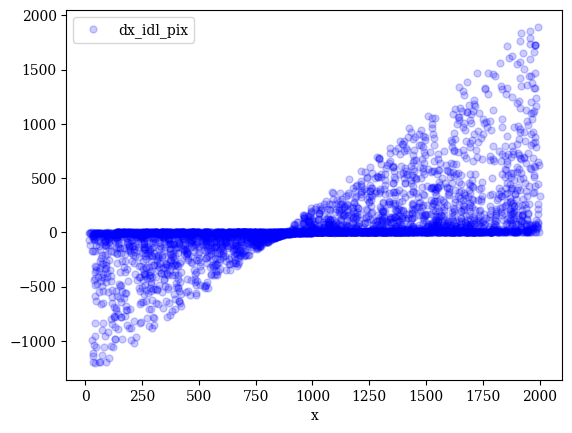

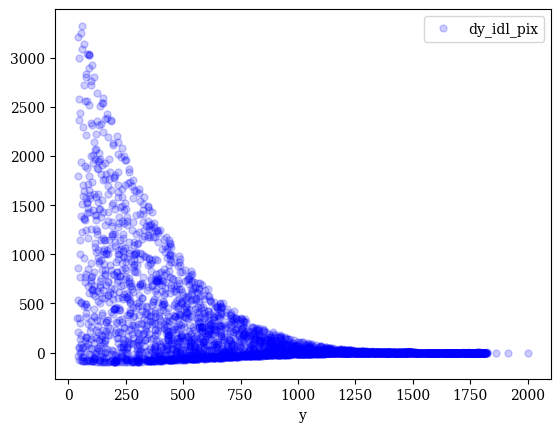

In [41]:
parity = siaf_aperture.VIdlParity
v3_ideal_y_angle = siaf_aperture.V3IdlYAngle * np.pi / 180.

refcat_v2_col4fit = 'refcat_v2'
refcat_v3_col4fit = 'refcat_v3'

for ix_imtable in imtable.getindices():
    imID=imtable.t.loc[ix_imtable,'imID']
    # correct for the v2v3 shift!
    ixs_imID =matches.ix_equal('imID',imID)
    print(f'{imID}: V3IdlYAnglecenter={imtable.t.loc[ix_imtable,"V3IdlYAnglecenter"]}')
    v2v32idlx, v2v32idly = v2v3_idl_model('v2v3', 'ideal', parity, imtable.t.loc[ix_imtable,'V3IdlYAnglecenter']* np.pi / 180.)

    matches.t.loc[ixs_imID,'refcat_x_idl'] = v2v32idlx(matches.t.loc[ixs_imID,refcat_v2_col4fit]-matches.t.loc[ixs_imID,'v2ref'],
                                                       matches.t.loc[ixs_imID,refcat_v3_col4fit]-matches.t.loc[ixs_imID,'v3ref'])
    matches.t.loc[ixs_imID,'refcat_y_idl'] = v2v32idly(matches.t.loc[ixs_imID,refcat_v2_col4fit]-matches.t.loc[ixs_imID,'v2ref'],
                                                       matches.t.loc[ixs_imID,refcat_v3_col4fit]-matches.t.loc[ixs_imID,'v3ref'])


#v2v32idlx, v2v32idly = v2v3_idl_model('v2v3', 'ideal', parity, v3_ideal_y_angle)
#idl2v2v3x, idl2v2v3y = v2v3_idl_model('ideal', 'v2v3', parity, v3_ideal_y_angle)

#matches.t['refcat_x_idl'] = v2v32idlx(matches.t['refcat_v2']-siaf_aperture.V2Ref,matches.t['refcat_v3']-siaf_aperture.V3Ref)
#matches.t['refcat_y_idl'] = v2v32idly(matches.t['refcat_v2']-siaf_aperture.V2Ref,matches.t['refcat_v3']-siaf_aperture.V3Ref)

matches.t['xprime'] =  matches.t['x'] + 1 - siaf_aperture.XSciRef 
matches.t['yprime'] =  matches.t['y'] + 1 - siaf_aperture.YSciRef 
#y_poly = pysiaf.utils.polynomial.polyfit(matches.t['refcat_y_idl'], matches.t['xprime'], matches.t['yprime'],order=5)

poly_degree = 5

ixs4fit = matches.getindices()
ixs4fit = matches.ix_inrange('y',1530,None,indices=ixs4fit)

coeff_Sci2IdlX = polyfit0(matches.t.loc[ixs4fit,'refcat_x_idl'], matches.t.loc[ixs4fit,'xprime'], matches.t.loc[ixs4fit,'yprime'],order=poly_degree)
coeff_Sci2IdlY = polyfit0(matches.t.loc[ixs4fit,'refcat_y_idl'], matches.t.loc[ixs4fit,'xprime'], matches.t.loc[ixs4fit,'yprime'],order=poly_degree)

matches.t['x_idl_fit'] = pysiaf.utils.polynomial.poly(coeff_Sci2IdlX, matches.t['xprime'], matches.t['yprime'], order=poly_degree)
matches.t['y_idl_fit'] = pysiaf.utils.polynomial.poly(coeff_Sci2IdlY, matches.t['xprime'], matches.t['yprime'], order=poly_degree)
matches.t['dx_idl_pix']  = (matches.t['refcat_x_idl'] - matches.t['x_idl_fit']) / coeff_Sci2IdlX[1]
matches.t['dy_idl_pix']  = (matches.t['refcat_y_idl'] - matches.t['y_idl_fit']) / coeff_Sci2IdlY[2]

matches.t['dx_idl_mas'] = (matches.t['refcat_x_idl'] - matches.t['x_idl_fit']) * 1000.0
matches.t['dy_idl_mas'] = (matches.t['refcat_y_idl'] - matches.t['y_idl_fit']) * 1000.0

for ix_imtable in imtable.getindices():
    imID=imtable.t.loc[ix_imtable,'imID']
    ixs_imID =matches.ix_equal('imID',imID)
    print(f'{imID}: V3IdlYAnglecenter={imtable.t.loc[ix_imtable,"V3IdlYAnglecenter"]}')
    idl2v2v3x, idl2v2v3y = v2v3_idl_model('ideal', 'v2v3', parity, imtable.t.loc[ix_imtable,'V3IdlYAnglecenter']* np.pi / 180.)

    matches.t['v2_fit'] = idl2v2v3x(matches.t['x_idl_fit'],matches.t['y_idl_fit'])+matches.t['v2ref']
    matches.t['v3_fit'] = idl2v2v3y(matches.t['x_idl_fit'],matches.t['y_idl_fit'])+matches.t['v3ref']

    #Get the image name and initialize model
    fullimagename = imtable.t.loc[ix_imtable,'fullimage']
    print(f'#############\nimID={imID}: {fullimagename}')
    image_model = ImageModel(fullimagename)
    v2v3_to_world = image_model.meta.wcs.get_transform('v2v3', 'world')
    (matches.t.loc[ixs_imID,'ra_fit'], matches.t.loc[ixs_imID,'dec_fit']) = v2v3_to_world(matches.t.loc[ixs_imID,'v2_fit'],matches.t.loc[ixs_imID,'v3_fit'])

matches.t['dra'] = (matches.t[colnames['ra']] - matches.t['ra_fit'])*3600.0
matches.t['ddec'] = (matches.t[colnames['dec']] - matches.t['dec_fit'])*3600.0

matches.t['dv2'] = matches.t['v2_fit'] - matches.t[refcat_v2_col4fit]
matches.t['dv3'] = matches.t['v3_fit'] - matches.t[refcat_v3_col4fit]


ixs=matches.getindices()
#ixs=matches.ix_equal('imID',0)

plot_style={}
plot_style['data1']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.2}
plot_style['data2']={'style':'o','color':'red', 'ms':5 ,'alpha':0.2}
plot_style['data3']={'style':'o','color':'green', 'ms':5 ,'alpha':0.2}

matches.t.loc[ixs].plot('x','dx_idl_pix', **plot_style['data1'])
matches.t.loc[ixs].plot('y','dy_idl_pix', **plot_style['data1'])
outfilebasename = f'/Users/arest/nircam/jwst_distortions_tools/newfit/gaia_v1/{apernamelist[0]}_{filtername}_{pupilname}.dxdyfit.txt'
matches.write(outfilebasename,verbose=2)


<Figure size 640x480 with 0 Axes>

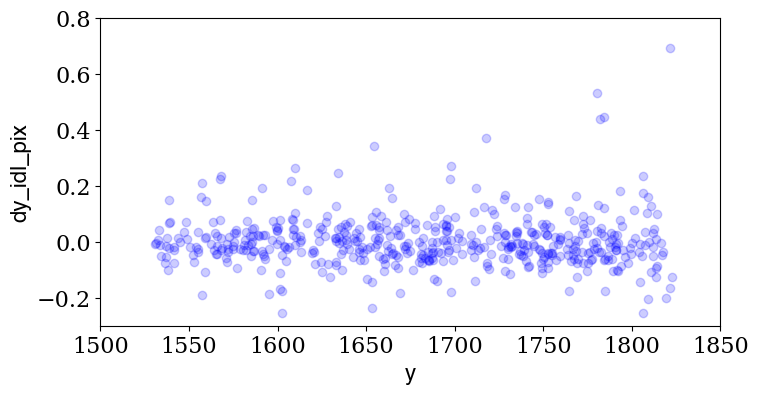

<Figure size 640x480 with 0 Axes>

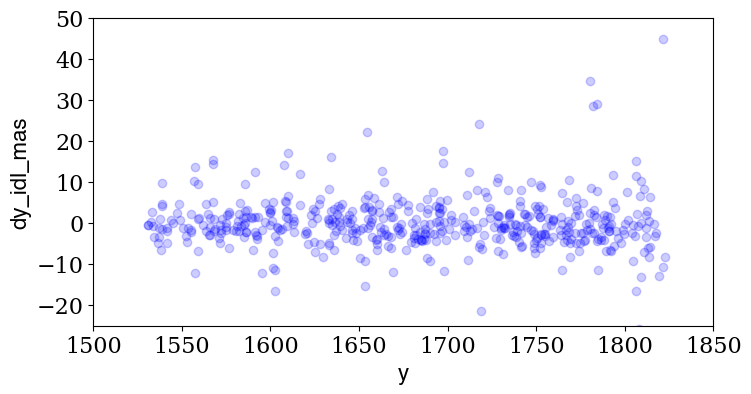

In [42]:
import matplotlib.pyplot as plt
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '16'}
plot_style['data1']={'fmt':'o','color':'blue', 'ms':5 ,'alpha':0.2}
def plotit(matches,xcol,ycol,indices=None,ymin=None,ymax=None,xmin=None,xmax=None):
    #sp = plt.subplot(111)
    
    plt.clf()
    plt.rc('font', family='serif')
    plt.figure(figsize=(8,4))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(xcol, fontdict=font2)
    plt.ylabel(ycol, fontdict=font2)
    ixs = matches.getindices(indices=indices)
    plt.plot(matches.t.loc[ixs,xcol],matches.t.loc[ixs,ycol],'bo',alpha=0.2)
    #matches.t.loc[ixs].plot(xcol,ycol, **plot_style['data1'])
    if ymin is not None:
        ax = plt.gca()
        ax.set_ylim([ymin, ymax])
    if xmin is not None:
        ax = plt.gca()
        ax.set_xlim([xmin, xmax])
    plt.show()

#plotit(matches,'x','dx_idl_pix',ymin=-0.3,ymax=0.3)
#plotit(matches,'x','dx_idl_mas',ymin=-9.3,ymax=9.3)
plotit(matches,'y','dy_idl_pix',ymin=-0.3,ymax=0.8,xmin=1500,xmax=1850,indices=ixs4fit)
plotit(matches,'y','dy_idl_mas',ymin=-25,ymax=50,xmin=1500,xmax=1850,indices=ixs4fit)


In [43]:
matches.calcaverage_sigmacutloop('dx_idl_pix',indices=ixs4fit,verbose=3,Nsigma=3,percentile_cut_firstiteration=95)
matches.calcaverage_sigmacutloop('dy_idl_pix',indices=ixs4fit,verbose=3,Nsigma=3,percentile_cut_firstiteration=95)


Keeping 514 out of 514, skippin 0 because of null values in columns dx_idl_pix
median: 0.015276
95.000000 percentile cut: max residual for cut: 0.259365
median: 0.017588
i:00 mean:0.017588(0.004224) stdev:0.093214(0.002984) X2norm:1.00 Nchanged:0 Ngood:488 Nclip:26

mean: 0.014604
i:01 mean:0.014604(0.004275) stdev:0.094533(0.003020) X2norm:1.00 Nchanged:2 Ngood:490 Nclip:24

mean: 0.014604
i:02 mean:0.014604(0.004275) stdev:0.094533(0.003020) X2norm:1.00 Nchanged:0 Ngood:490 Nclip:24
Keeping 514 out of 514, skippin 0 because of null values in columns dy_idl_pix
median: -0.008862
95.000000 percentile cut: max residual for cut: 0.225487
median: -0.009112
i:00 mean:-0.009112(0.003173) stdev:0.070014(0.002241) X2norm:1.00 Nchanged:0 Ngood:488 Nclip:26

mean: -0.005539
i:01 mean:-0.005539(0.003113) stdev:0.068560(0.002199) X2norm:1.00 Nchanged:2 Ngood:486 Nclip:28

mean: -0.005539
i:02 mean:-0.005539(0.003113) stdev:0.068560(0.002199) X2norm:1.00 Nchanged:0 Ngood:486 Nclip:28


False

In [10]:
outfilebasename = f'/Users/arest/nircam/jwst_distortions_tools/newfit/gaia_v1/{apernamelist[0]}_{filtername}_{pupilname}.dxdyfit.txt'
matches.write(outfilebasename,verbose=2)

Saving 2177 rows into /Users/arest/nircam/jwst_distortions_tools/newfit/gaia_v1/NRCA4_FULL_F150W_CLEAR.dxdyfit.txt


0

AttributeError: Line2D.set() got an unexpected keyword argument 'fmt'

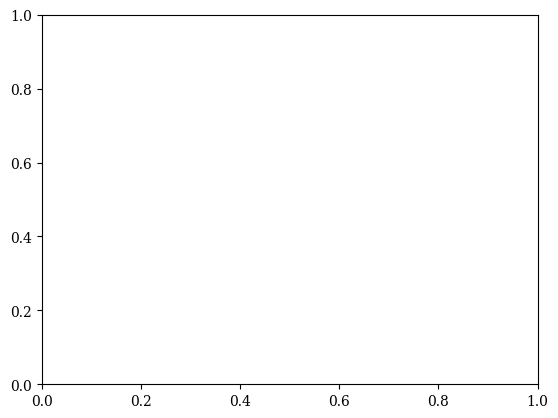

In [44]:
matches.t.loc[ixs].plot('x','dx_idl_pix', **plot_style['data1'])
matches.t.loc[ixs].plot('x','dx_idl_mas', **plot_style['data1'])
matches.t.loc[ixs].plot('y','dy_idl_pix', **plot_style['data1'])
matches.t.loc[ixs].plot('x','y', **plot_style['data1'])

<AxesSubplot: xlabel='v3_fit'>

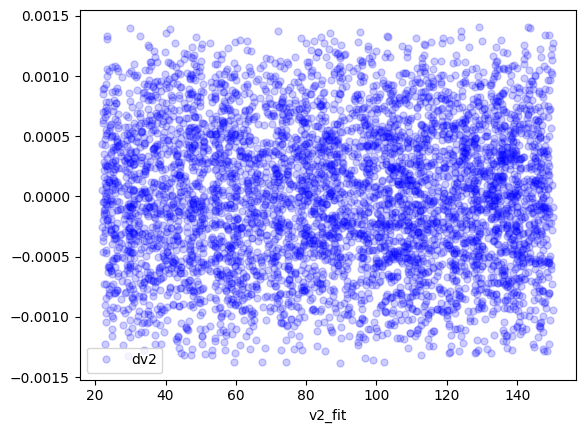

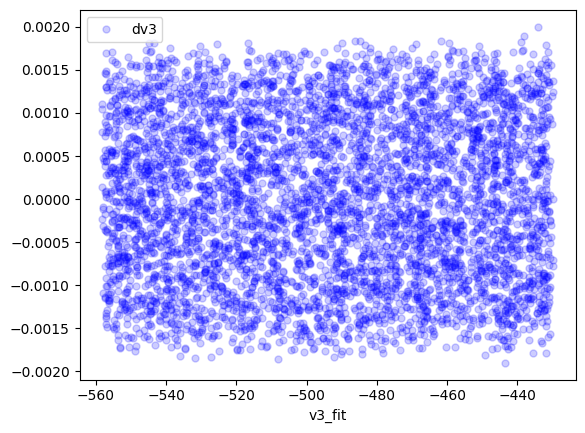

In [15]:
matches.t.loc[ixs].plot('v2_fit','dv2', **plot_style['data1'])
matches.t.loc[ixs].plot('v3_fit','dv3', **plot_style['data1'])


<AxesSubplot: xlabel='x'>

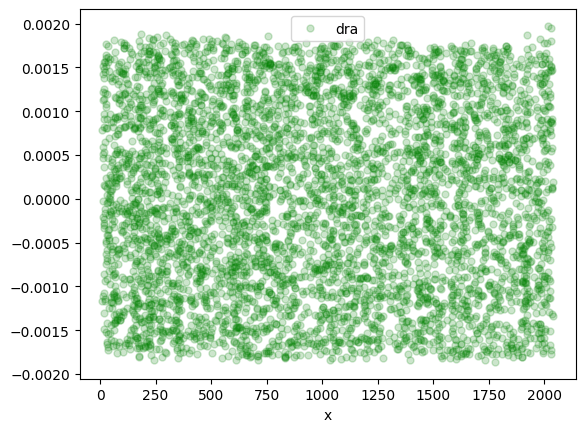

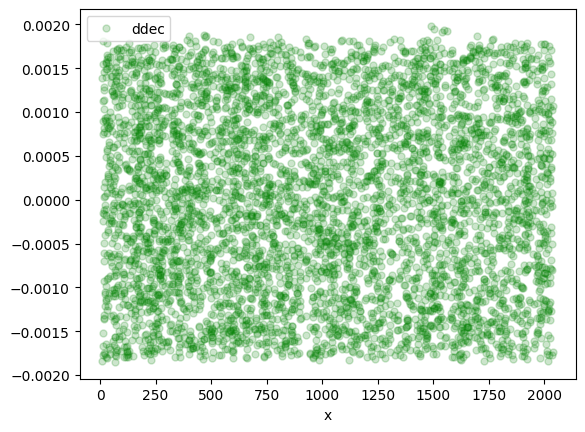

In [10]:
matches.t.loc[ixs].plot('x','dra', **plot_style['data3'])
matches.t.loc[ixs].plot('x','ddec', **plot_style['data3'])


<AxesSubplot: xlabel='x'>

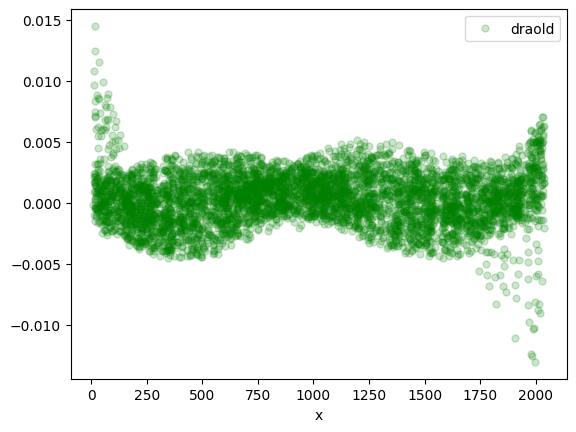

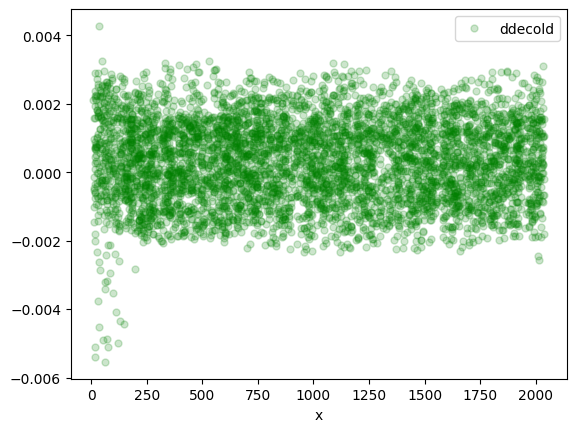

In [11]:
matches.t.loc[ixs].plot('x','draold', **plot_style['data3'])
matches.t.loc[ixs].plot('x','ddecold', **plot_style['data3'])


<AxesSubplot: xlabel='dec'>

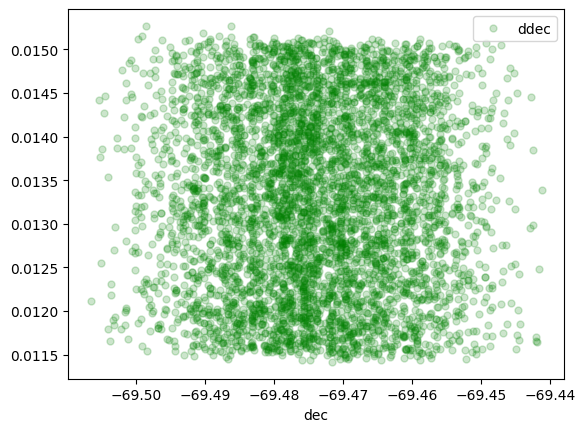

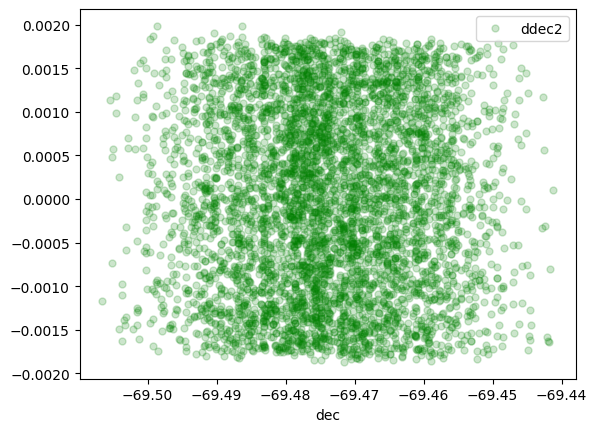

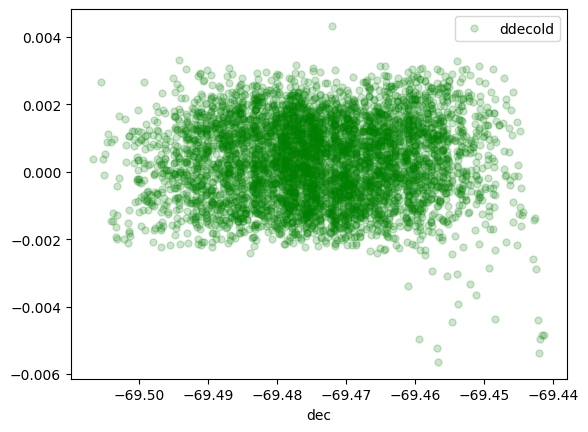

In [32]:
matches.t.loc[ixs].plot('dec','ddec', **plot_style['data3'])
matches.t.loc[ixs].plot('dec','ddec2', **plot_style['data3'])
matches.t.loc[ixs].plot('dec','ddecold', **plot_style['data3'])


In [38]:
matches.calcaverage_sigmacutloop('dx_idl_pix',verbose=3,percentile_cut_firstiteration=95)

Keeping 594 out of 594, skippin 0 because of null values in columns dx_idl_pix
median: 0.002259
95.000000 percentile cut: max residual for cut: 0.127590
median: 0.002495
i:00 mean:0.002495(0.002084) stdev:0.049439(0.001472) X2norm:1.00 Nchanged:0 Ngood:564 Nclip:30

mean: 0.001476
i:01 mean:0.001476(0.002184) stdev:0.052271(0.001543) X2norm:1.00 Nchanged:10 Ngood:574 Nclip:20

mean: 0.001739
i:02 mean:0.001739(0.002221) stdev:0.053292(0.001569) X2norm:1.00 Nchanged:3 Ngood:577 Nclip:17

mean: 0.001739
i:03 mean:0.001739(0.002221) stdev:0.053292(0.001569) X2norm:1.00 Nchanged:0 Ngood:577 Nclip:17


False

In [42]:
matches.calcaverage_sigmacutloop('dy_idl_pix',verbose=3,Nsigma=5,percentile_cut_firstiteration=95)

Keeping 594 out of 594, skippin 0 because of null values in columns dy_idl_pix
median: -0.010117
95.000000 percentile cut: max residual for cut: 0.133537
median: -0.010916
i:00 mean:-0.010916(0.002004) stdev:0.047550(0.001416) X2norm:1.00 Nchanged:0 Ngood:564 Nclip:30

mean: -0.009534
i:01 mean:-0.009534(0.002278) stdev:0.054905(0.001609) X2norm:1.00 Nchanged:18 Ngood:582 Nclip:12

mean: -0.009068
i:02 mean:-0.009068(0.002321) stdev:0.056004(0.001640) X2norm:1.00 Nchanged:1 Ngood:583 Nclip:11

mean: -0.009068
i:03 mean:-0.009068(0.002321) stdev:0.056004(0.001640) X2norm:1.00 Nchanged:0 Ngood:583 Nclip:11


False

<AxesSubplot: xlabel='ddec2'>

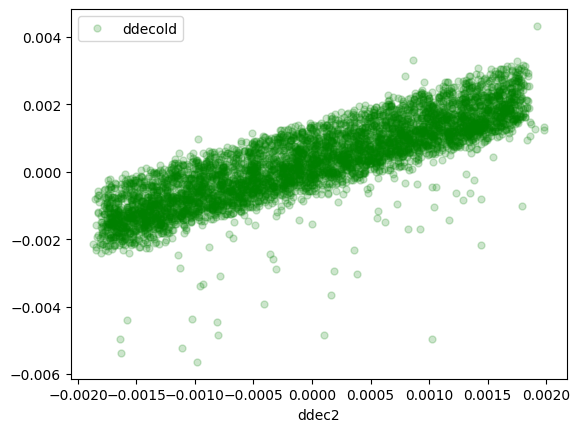

In [35]:
matches.t.loc[ixs].plot('ddec2','ddecold', **plot_style['data3'])

<AxesSubplot: xlabel='ra'>

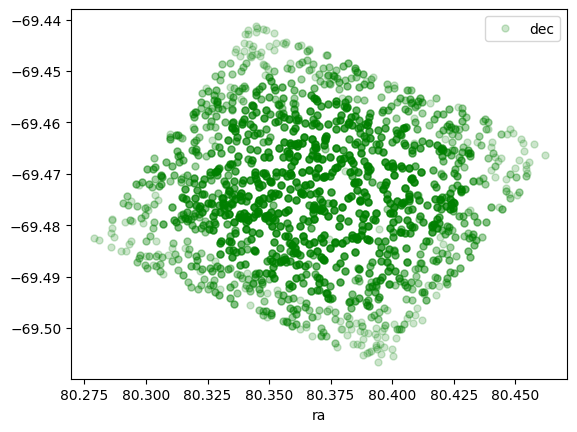

In [36]:
matches.t.loc[ixs].plot('ra','dec', **plot_style['data3'])